In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.figsize'] = (20, 5)

In [2]:
def get_rms(data, n):
    new = np.zeros(data.shape)
    for channel in range(data.shape[1]):
        for current in range(data.shape[0]):
            suma = 0
            for window in range(current, current - n, -1):
                suma += data[window, channel] * data[window, channel]
            new[current, channel] = (np.sqrt((1/n)*suma) / 128) if channel != 8 else data[current, channel]
    #plt.figure()
    #plt.plot(data)
    #plt.figure()
    #plt.plot(new)
    return new

def peel_labels(data):
    return data[:,:8], data[:,8]

def get_values(seshes, skip_hibernation):
    big_matrix = np.zeros((0, 9))
    for sesh in seshes:
        for gesture in range(8):
            wei = sesh + "/" + str(gesture) + ".txt"
            print(wei)
            matrix = np.genfromtxt(wei, delimiter=",")
            rms = get_rms(matrix, 80)
            #plt.figure()
            #plt.plot(rms)
            if skip_hibernation:
                rms = rms[rms[:,8] != 0]
                rms[:,8] -= 1
            #plt.figure()
            #plt.plot(rms)
            big_matrix = np.concatenate((big_matrix, rms), axis = 0)
    return big_matrix

In [3]:
'''
#gotta go fast
skip_hibernation = False
readings = "../myo-readings-dataset/_readings/"
seshes = [x[0] for x in os.walk(readings)][1:]
print(*seshes, sep = "\n")
print("kekw")

start = 22

train_set, valid_set, test_set = get_values([seshes[start]], skip_hibernation), \
                                 get_values([seshes[start + 1]], skip_hibernation), \
                                 get_values([seshes[start + 2]], skip_hibernation)

train, train_labels = peel_labels(train_set)
valid, valid_labels = peel_labels(valid_set)
test, test_labels = peel_labels(test_set)
'''

'\n#gotta go fast\nskip_hibernation = False\nreadings = "../myo-readings-dataset/_readings/"\nseshes = [x[0] for x in os.walk(readings)][1:]\nprint(*seshes, sep = "\n")\nprint("kekw")\n\nstart = 22\n\ntrain_set, valid_set, test_set = get_values([seshes[start]], skip_hibernation),                                  get_values([seshes[start + 1]], skip_hibernation),                                  get_values([seshes[start + 2]], skip_hibernation)\n\ntrain, train_labels = peel_labels(train_set)\nvalid, valid_labels = peel_labels(valid_set)\ntest, test_labels = peel_labels(test_set)\n'

In [4]:

#selected sessions
selection = [22, 23, 24, 25, 26, 27, 28, 29, 30, 34, 35, 36, 53, 55, 57]
skip_hibernation = False
readings = "../myo-readings-dataset/_readings/"
seshes = [x[0] for x in os.walk(readings)][1:]
seshes = [seshes[i] for i in selection]
print(*seshes, sep = "\n")
print("kekw")
np.random.shuffle(seshes)

siz = len(seshes)
split1 = int(0.6 * siz)
split2 = int(0.8 * siz)

train_set, valid_set, test_set = get_values(seshes[:split1], skip_hibernation), \
                                 get_values(seshes[split1:split2], skip_hibernation), \
                                 get_values(seshes[split2:], skip_hibernation)

train, train_labels = peel_labels(train_set)
valid, valid_labels = peel_labels(valid_set)
test, test_labels = peel_labels(test_set)


../myo-readings-dataset/_readings/Seja 01
../myo-readings-dataset/_readings/Seja 02
../myo-readings-dataset/_readings/Seja 03
../myo-readings-dataset/_readings/Seja 1
../myo-readings-dataset/_readings/Seja 2
../myo-readings-dataset/_readings/Seja 3
../myo-readings-dataset/_readings/seja-1
../myo-readings-dataset/_readings/seja-2
../myo-readings-dataset/_readings/seja-3
../myo-readings-dataset/_readings/seja_ao_1
../myo-readings-dataset/_readings/seja_ao_2
../myo-readings-dataset/_readings/seja_ao_3
../myo-readings-dataset/_readings/session_1_SH
../myo-readings-dataset/_readings/session_2_SH
../myo-readings-dataset/_readings/session_3_SH
kekw
../myo-readings-dataset/_readings/session_3_SH/0.txt
../myo-readings-dataset/_readings/session_3_SH/1.txt
../myo-readings-dataset/_readings/session_3_SH/2.txt
../myo-readings-dataset/_readings/session_3_SH/3.txt
../myo-readings-dataset/_readings/session_3_SH/4.txt
../myo-readings-dataset/_readings/session_3_SH/5.txt
../myo-readings-dataset/_reading

In [5]:
'''
#all sessions
skip_hibernation = False
readings = "../myo-readings-dataset/_readings/"
seshes = [x[0] for x in os.walk(readings)][1:]
np.random.shuffle(seshes)
print(*seshes, sep = "\n")
print("kekw")

siz = len(seshes)
split1 = int(0.6 * siz)
split2 = int(0.8 * siz)
train_set, valid_set, test_set = get_values(seshes[:split1], skip_hibernation), \
                                 get_values(seshes[split1:split2], skip_hibernation), \
                                 get_values(seshes[split2:], skip_hibernation)

train, train_labels = peel_labels(train_set)
valid, valid_labels = peel_labels(valid_set)
test, test_labels = peel_labels(test_set)
'''

'\n#all sessions\nskip_hibernation = False\nreadings = "../myo-readings-dataset/_readings/"\nseshes = [x[0] for x in os.walk(readings)][1:]\nnp.random.shuffle(seshes)\nprint(*seshes, sep = "\n")\nprint("kekw")\n\nsiz = len(seshes)\nsplit1 = int(0.6 * siz)\nsplit2 = int(0.8 * siz)\ntrain_set, valid_set, test_set = get_values(seshes[:split1], skip_hibernation),                                  get_values(seshes[split1:split2], skip_hibernation),                                  get_values(seshes[split2:], skip_hibernation)\n\ntrain, train_labels = peel_labels(train_set)\nvalid, valid_labels = peel_labels(valid_set)\ntest, test_labels = peel_labels(test_set)\n'

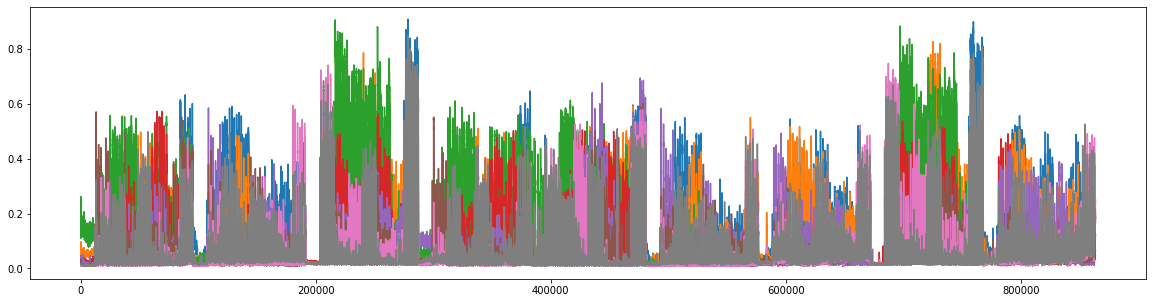

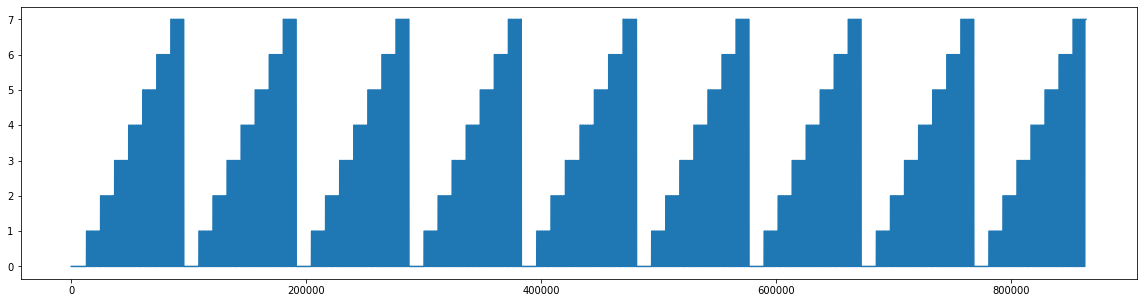

In [6]:
plt.figure()
plt.plot(train)
plt.figure()
plt.plot(train_labels)

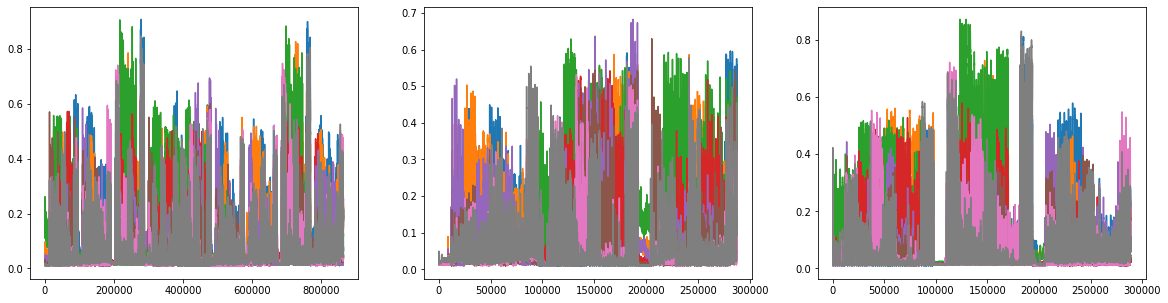

In [7]:
fig, ax = plt.subplots(1, 3)
ax[0].plot(train)
ax[1].plot(valid)
ax[2].plot(test)

In [8]:
model = keras.Sequential([
    keras.layers.Dense(200, activation = "relu", input_shape = (8,)),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(70, activation = "relu"),
    keras.layers.Dense(7 if skip_hibernation else 8, activation = "sigmoid")
])

opt = keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer = opt, loss = loss, metrics = ["accuracy"])

In [9]:
model_checkpoint = ModelCheckpoint("weights.h5", save_best_only = True, save_weights_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)
history = model.fit(train, train_labels, 
                    validation_data = (valid, valid_labels), 
                    epochs = 20, 
                    callbacks = [early_stopping, model_checkpoint])
model.load_weights("weights.h5")

Epoch 1/20
26988/26988 [==============================] - 30s 1ms/step - loss: 0.4748 - accuracy: 0.8635 - val_loss: 0.6558 - val_accuracy: 0.8325
Epoch 2/20
26988/26988 [==============================] - 29s 1ms/step - loss: 0.2683 - accuracy: 0.9259 - val_loss: 0.7189 - val_accuracy: 0.8356
Epoch 3/20
26988/26988 [==============================] - 27s 987us/step - loss: 0.2319 - accuracy: 0.9339 - val_loss: 0.8463 - val_accuracy: 0.8276
Epoch 4/20
26988/26988 [==============================] - 27s 990us/step - loss: 0.2075 - accuracy: 0.9394 - val_loss: 0.8577 - val_accuracy: 0.8185
Epoch 5/20
26988/26988 [==============================] - 24s 905us/step - loss: 0.1908 - accuracy: 0.9435 - val_loss: 0.8950 - val_accuracy: 0.8175
Epoch 6/20
26988/26988 [==============================] - 24s 878us/step - loss: 0.1780 - accuracy: 0.9465 - val_loss: 1.0478 - val_accuracy: 0.8065


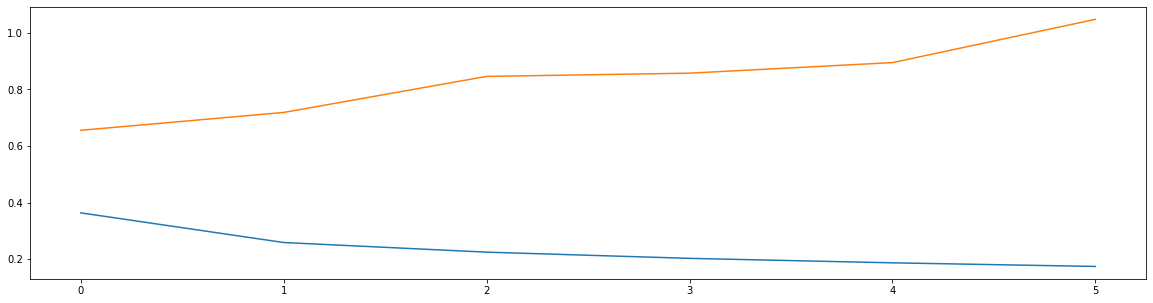

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

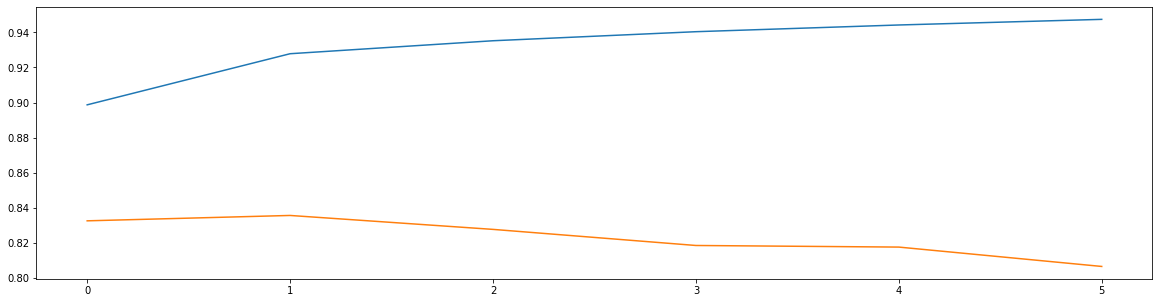

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [12]:
model.evaluate(test, test_labels)

9042/9042 [==============================] - 4s 472us/step - loss: 0.6429 - accuracy: 0.8221


[0.6428974866867065, 0.8221291899681091]

In [13]:
predictions = model.predict(test)

In [14]:
predicted_labels = np.argmax(predictions, axis=1)
conf = confusion_matrix(test_labels, predicted_labels, normalize="pred")
conf

array([[8.64970734e-01, 8.20694304e-02, 6.82707562e-02, 1.02070217e-01,
        5.22661850e-02, 9.42649967e-02, 1.61661618e-01, 7.92806662e-02],
       [3.12468159e-02, 6.52960342e-01, 0.00000000e+00, 0.00000000e+00,
        8.46644466e-04, 4.76085842e-03, 3.11553440e-03, 5.94779931e-02],
       [9.46461525e-03, 0.00000000e+00, 8.04918033e-01, 3.48948885e-02,
        7.90201501e-04, 4.61437047e-03, 4.89831242e-02, 0.00000000e+00],
       [1.04722118e-02, 1.96607123e-03, 0.00000000e+00, 8.31714865e-01,
        0.00000000e+00, 3.29597891e-03, 3.92038079e-02, 2.01525436e-02],
       [2.09387630e-02, 2.19076508e-03, 3.75991539e-02, 0.00000000e+00,
        7.59609415e-01, 1.46487951e-04, 2.28472523e-02, 6.99741096e-05],
       [7.94755969e-03, 1.36501517e-01, 7.85827604e-02, 2.54508590e-02,
        8.41000169e-03, 8.02753973e-01, 1.09043704e-01, 0.00000000e+00],
       [3.76376954e-02, 1.24031008e-01, 3.12004231e-03, 3.36143421e-03,
        6.77880002e-02, 9.01633341e-02, 5.35785374e-01, 0.

In [15]:
if skip_hibernation:
    legend = ["flexion", "extension", "radial deviation", "ulnar deviation", "pronation", "supination", "fist"]
else:
    legend = ["hibernation", "flexion", "extension", "radial deviation", "ulnar deviation", "pronation", "supination", "fist"]

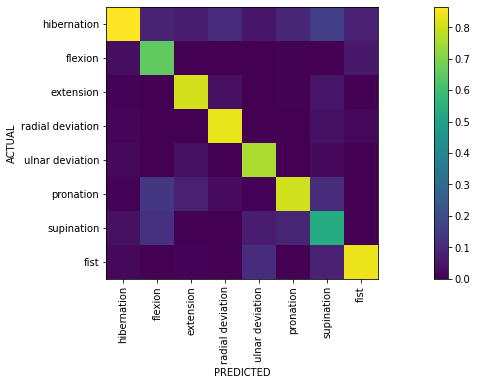

In [16]:
plt.imshow(conf)
plt.ylabel("ACTUAL")
plt.xlabel("PREDICTED")
plt.yticks(np.arange(len(legend)), legend)
plt.xticks(np.arange(len(legend)), legend, rotation='vertical')
plt.colorbar()

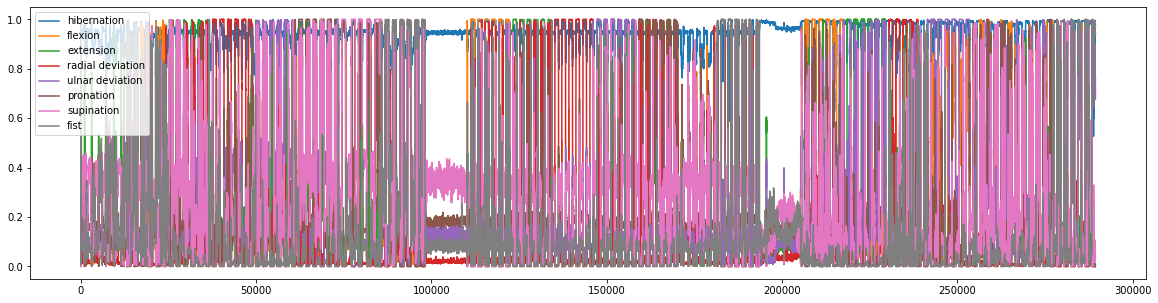

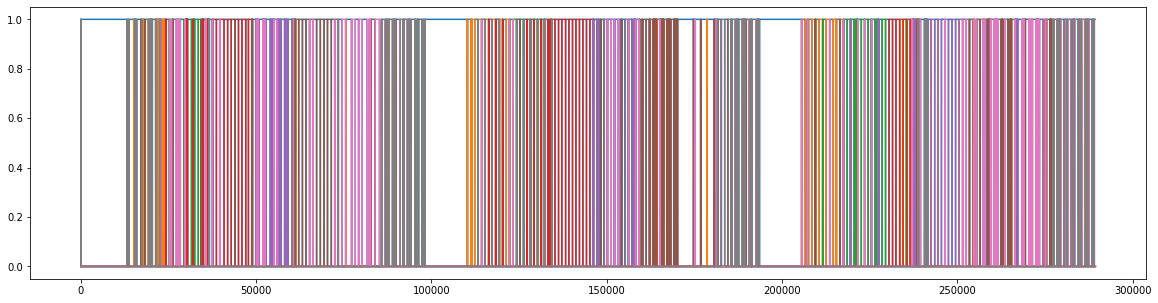

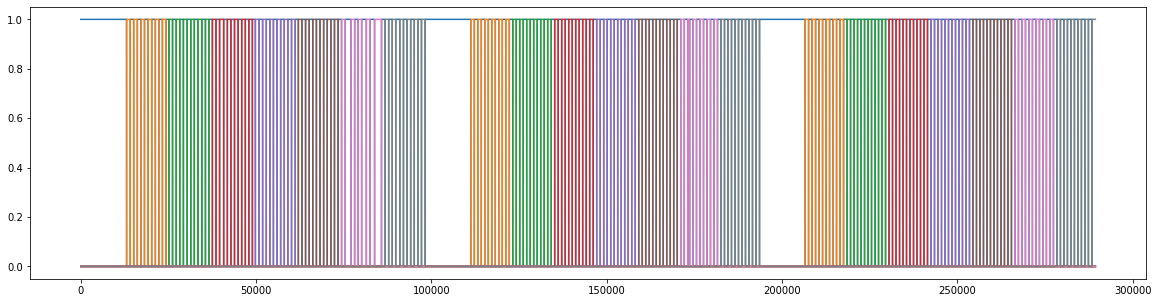

In [17]:
plt.figure()
plt.plot(predictions)
plt.legend(legend, loc = "upper left")

predicted_labels_onehot = keras.utils.to_categorical(predicted_labels, num_classes = 7 if skip_hibernation else 8)
test_labels_onehot = keras.utils.to_categorical(test_labels, num_classes = 7 if skip_hibernation else 8)

plt.figure()
plt.plot(predicted_labels_onehot)

plt.figure()
plt.plot(test_labels_onehot)

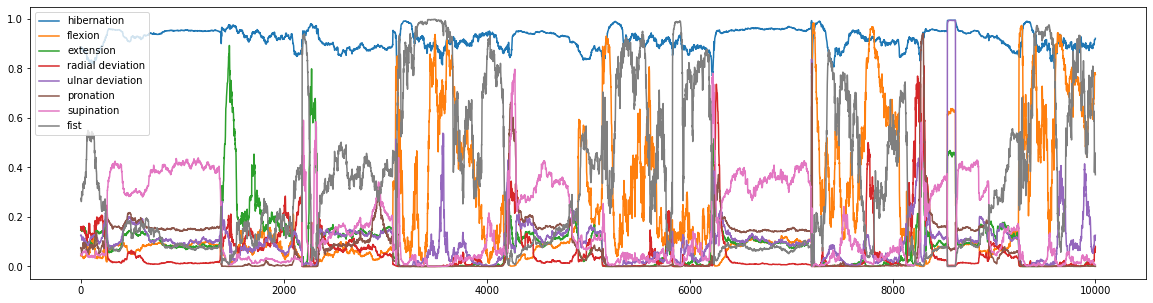

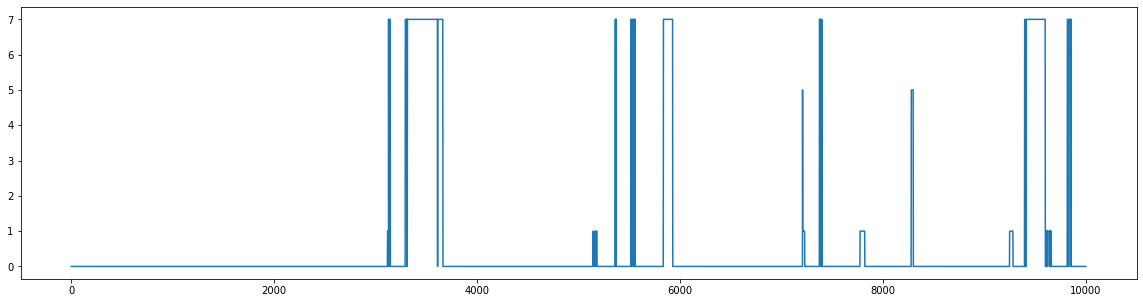

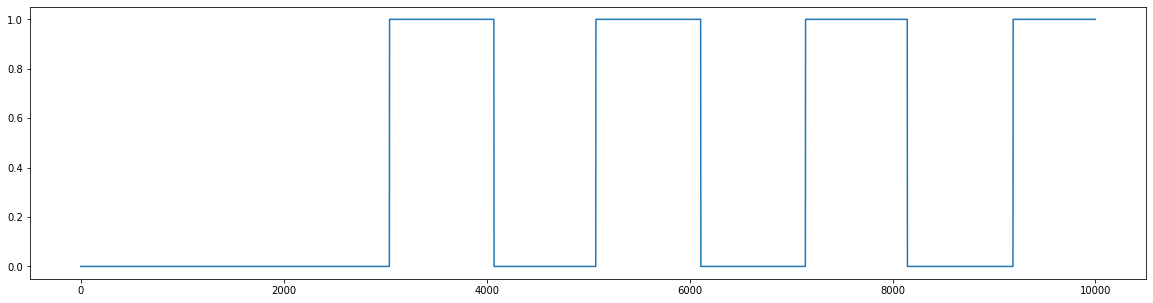

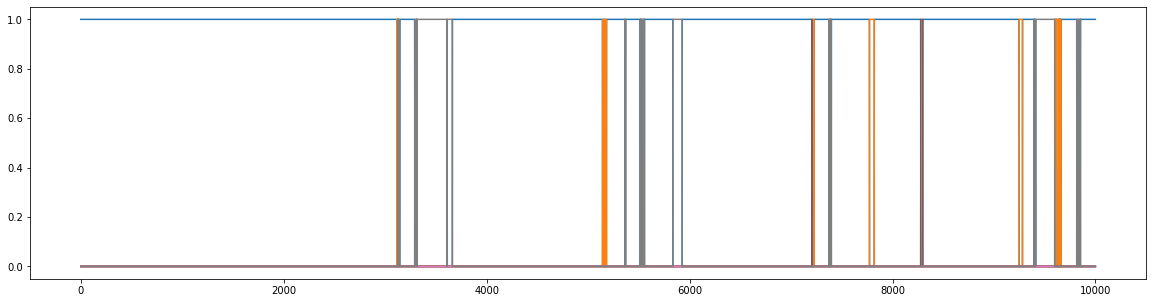

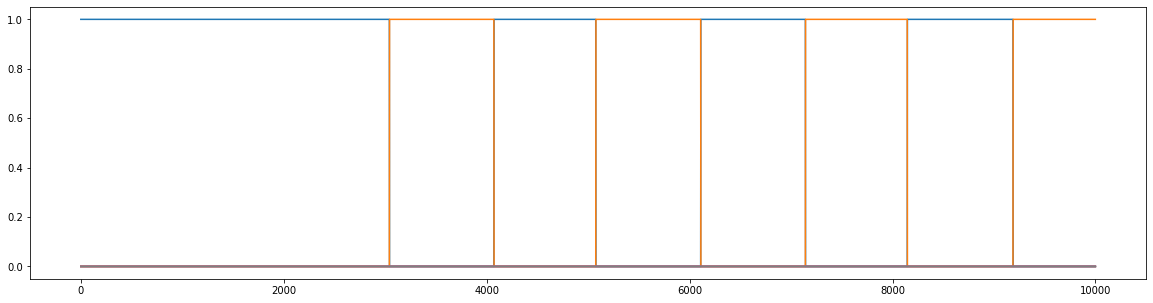

In [18]:
plt.figure()
plt.plot(predictions[10000:20000])
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(predicted_labels[10000:20000])
plt.figure()
plt.plot(test_labels[10000:20000])
plt.figure()
plt.plot(predicted_labels_onehot[10000:20000])
plt.figure()
plt.plot(test_labels_onehot[10000:20000])

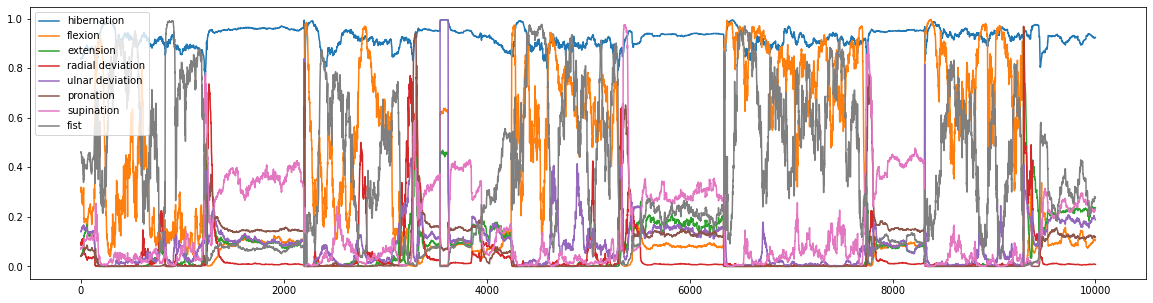

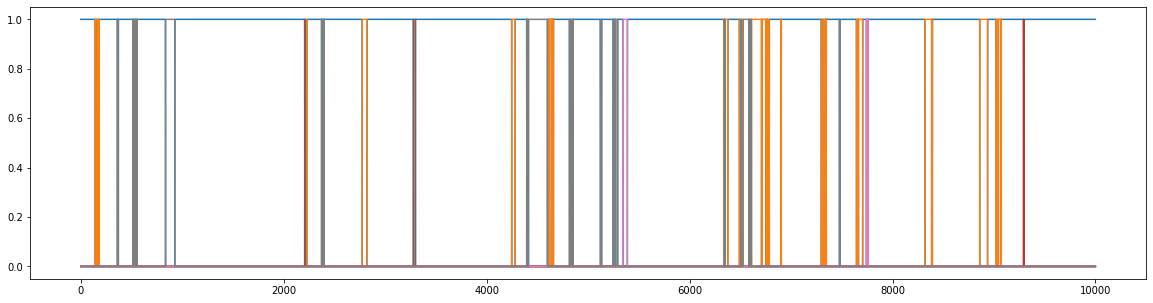

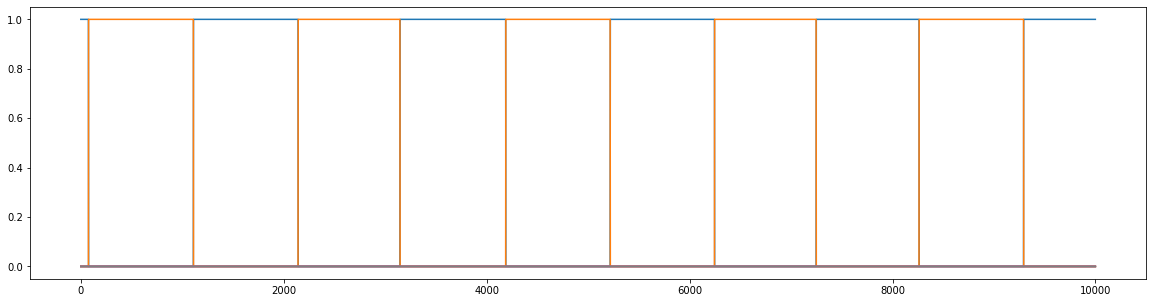

In [19]:
plt.figure()
plt.plot(predictions[15000:25000])
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(predicted_labels_onehot[15000:25000])
plt.figure()
plt.plot(test_labels_onehot[15000:25000])

In [20]:
training_analysis = model.predict(train)

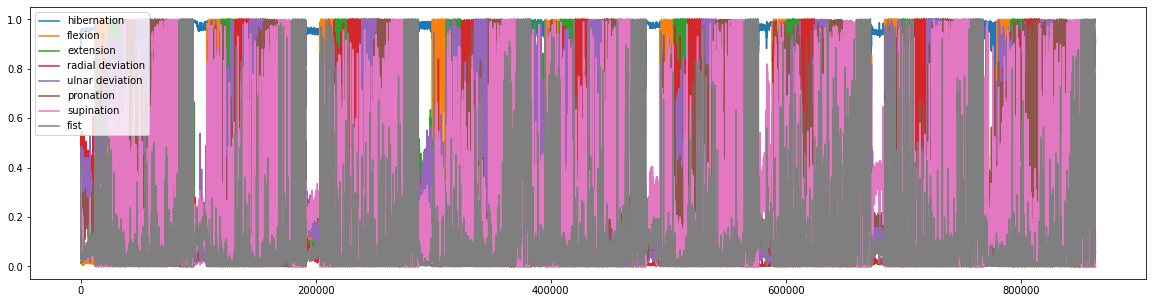

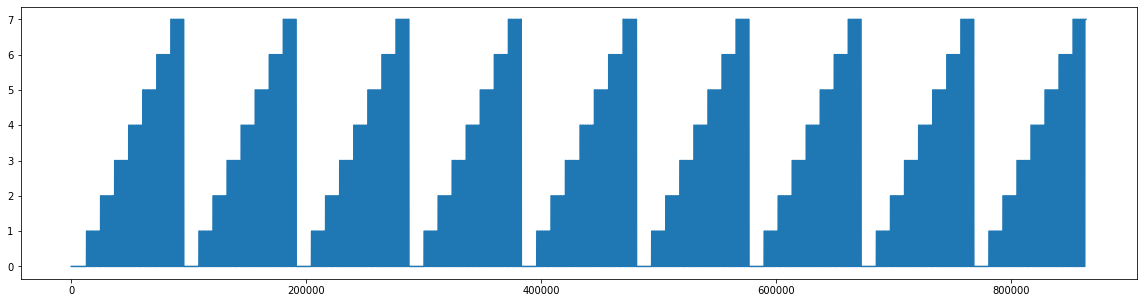

In [21]:
plt.figure()
plt.plot(training_analysis)
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(train_labels)

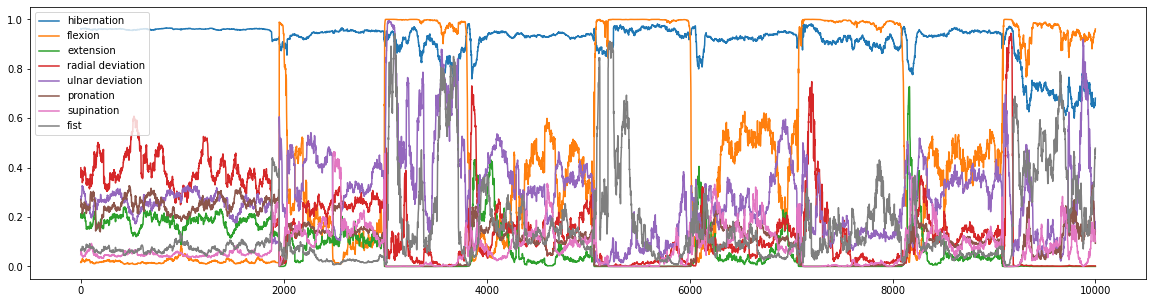

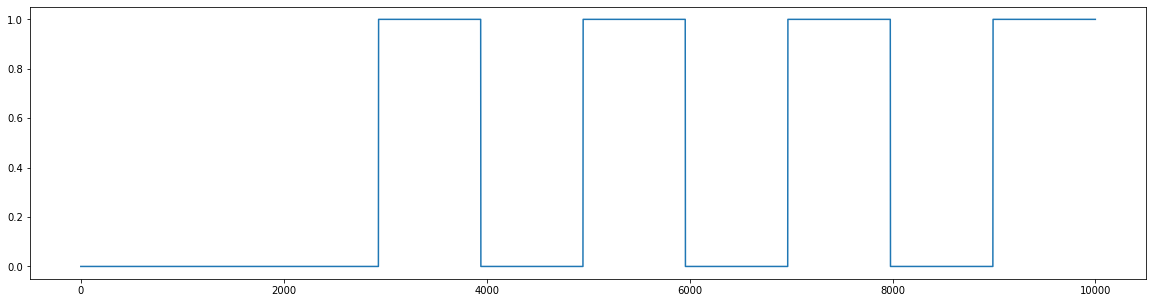

In [22]:
plt.figure()
plt.plot(training_analysis[10000:20000])
plt.legend(legend, loc = "upper left")
plt.figure()
plt.plot(train_labels[10000:20000])